In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd 
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse
from unidecode import unidecode

import xarray as xr
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%load_ext autoreload
%autoreload 2

### 1 Read historical wheat data 
- for Argentina on municipality level, from 1969-2022 (https://datosestimaciones.magyp.gob.ar/)

In [2]:
df = (pd
      .read_csv("files/crop data/historical_wheat_data_argentina.csv", encoding="latin-1", sep=";")
      .drop(columns={"Cultivo", "idProvincia", "idDepartamento", "Sup. Sembrada"}))

df.columns = ["year", "province", "municipality", "harvested area [ha]", "production [t]", "yield [kg/ha]"]
df["year"] = df["year"].str[:4].astype(int)

# Add name column
df["province"] = df["province"].str.lower().apply(lambda x: unidecode(x))
df["municipality"] = df["municipality"].str.lower().apply(lambda x: unidecode(x))
df["name"] = df["province"] + " " + df["municipality"]
df = df[["year", "province", "municipality", "name", "production [t]", "harvested area [ha]", "yield [kg/ha]"]]

df.head(2)

,year,province,municipality,name,production [t],harvested area [ha],yield [kg/ha]
0,1969,buenos aires,25 de mayo,buenos aires 25 de mayo,71400,42000,1700
1,1970,buenos aires,25 de mayo,buenos aires 25 de mayo,54000,36000,1500


### 2. Filter relevant provinces & municipalities

#### 2.1 By highest production

In [3]:
production_by_province = df.groupby("province")["production [t]"].sum().reset_index().sort_values(by="production [t]", ascending=False).reset_index(drop=True)
production_by_province["production cumsum [%]"] = np.round(100 * production_by_province["production [t]"] / df["production [t]"].sum()).cumsum()

df = df.loc[df["province"].isin(production_by_province.iloc[:5]["province"].unique())].reset_index(drop=True)

#### 2.2 By complete time series

In [4]:
complete_areas = (
    df.loc[df["year"].between(1993, 2016)]
    .groupby("name")
    .size()
    .reset_index(name="count")
    .loc[lambda x: x["count"] == 24, "name"]
    .unique()
    .tolist()
)

df = df.loc[df["name"].isin(complete_areas)].reset_index(drop=True)
df.head(2)

,year,province,municipality,name,production [t],harvested area [ha],yield [kg/ha]
0,1969,buenos aires,25 de mayo,buenos aires 25 de mayo,71400,42000,1700
1,1970,buenos aires,25 de mayo,buenos aires 25 de mayo,54000,36000,1500


### 3.  Preprocess

#### 3.1 Define study region

In [5]:
# read subnational wheat series and store unique region names
relevant_areas = df["name"].unique()

# Read ADM1 shapefiles
gdf_adm1 = gpd.read_file("files/shapefiles/arg_admbnda_adm1_unhcr2017.shp").to_crs("EPSG:4326")

# Read ADM2 shapefiles (municipality level) and filter by relevant states
gdf_adm2 = gpd.read_file("files/shapefiles/arg_admbnda_adm2_unhcr2017.shp")
#gdf_adm2["ADM2_ES"] = gdf_adm2["ADM2_ES"].str.lower().apply(lambda x: unidecode(x))
#gdf_adm2["ADM1_ES"] = gdf_adm2["ADM1_ES"].str.lower().apply(lambda x: unidecode(x))
gdf_adm2["name"] = gdf_adm2["ADM1_ES"].str.lower().apply(lambda x: unidecode(x)) + " " + gdf_adm2["ADM2_ES"].str.lower().apply(lambda x: unidecode(x))

# filter areas 
gdf_adm2 = gdf_adm2.loc[gdf_adm2["name"].isin(relevant_areas), ["ADM1_ES", "name", "geometry"]].reset_index(drop=True)

# study region as multipolygon
study_region = gdf_adm2.dissolve().assign(name="study region")

study_region.to_file('files/shapefiles/study_region.shp', driver='ESRI Shapefile')

#### 3.2 Weighted aggregation to national level

In [24]:
df_national = (
    df.assign(yield_weighted=df["yield [kg/ha]"] * df["harvested area [ha]"])
    .groupby("year")
    .agg({"harvested area [ha]": "sum", "yield_weighted": "sum"})
    .assign(yield_kg_per_ha=lambda x: x["yield_weighted"] / x["harvested area [ha]"])
    .reset_index()
    .rename(columns={"yield_kg_per_ha": "yield [kg/ha]"})
    [["year", "harvested area [ha]", "yield [kg/ha]"]]
)

df_national.head()


,year,harvested area [ha],yield [kg/ha]
0,1969,5084940,1360.855654
1,1970,3582000,1332.279726
2,1971,4198650,1266.784324
3,1972,4848950,1605.905134
4,1973,3842190,1665.859844


#### 3.3 Detrend national yield

In [25]:
def estimate_trend(df):
    # dictionary that stores for each year the slope and bias estimated from the previous years
    years_to_params = {}
    for year in list(range(1993,2023)):
        years_to_params[year] = {"slope":np.nan, "bias":np.nan}
        # from the wheat dataset get the 23 preceding years to the current year, e.g. for year 1993, get 1969-1992
        year_range = df.loc[df["year"].isin(list(range(year-23, year))), ["year", "yield [kg/ha]"]]
        # estimate slope and bias of a linear fit through these preceding years and store them in dictionary
        slope, bias = np.polyfit(year_range["year"], year_range["yield [kg/ha]"], deg=1)
        years_to_params[year]["slope"] = slope
        years_to_params[year]["bias"] = bias
        
    trend_estimated = []
    relevant_years = list(range(1993, 2022))
    for year in relevant_years:
        value = year * years_to_params[year]["slope"] + years_to_params[year]["bias"]
        trend_estimated.append(value)
            
    return trend_estimated

In [26]:
# Trend estimation
trend_estimated = estimate_trend(df_national)

# Detrending with multiplicative decomposition
df_national = df_national.loc[df_national["year"].between(1993, 2023)].reset_index(drop=True)
df_national["yield trend [kg/ha]"] = trend_estimated
df_national["yield anomaly [%]"] = (df_national["yield [kg/ha]"] - df_national["yield trend [kg/ha]"]) / df_national["yield trend [kg/ha]"]

#### 3.4 Plot

371.26


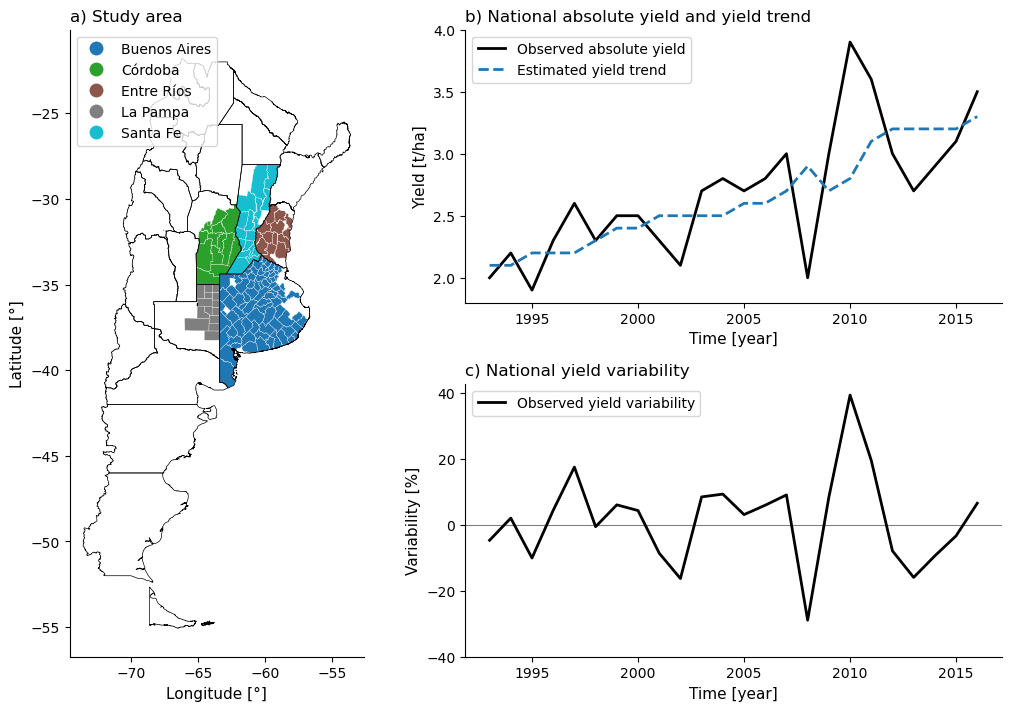

In [30]:
# Create subplots
fig, axd = plt.subplot_mosaic([['left', 'upper right'],
                               ['left', 'lower right']],
                              figsize=(10, 7), layout="constrained", width_ratios=[0.4, 0.6])

# Figure a) Study region
gdf_adm2.plot(ax=axd["left"], column="ADM1_ES", edgecolor="white", linewidth=.2, legend=True, legend_kwds={"loc":"upper left"})
gdf_adm1.plot(ax=axd["left"], color="#FF000000", edgecolor="black", linewidth=0.5)
axd['left'].set_title("a) Study area", loc="left", size=12);
axd['left'].set_ylabel("Latitude [°]", size=11);
axd['left'].set_xlabel("Longitude [°]", size=11);
axd['left'].spines[['right', 'top']].set_visible(False)

# Figure b) Absolute yield and trend
trend_estimates_t_ha = [np.round(x/1000, 1) for x in trend_estimated]
absolute_yield_t_ha = [np.round(x/1000, 1) for x in df_national["yield [kg/ha]"].values.tolist()]
axd['upper right'].plot(list(range(1993, 2022))[:-5], absolute_yield_t_ha[:-5], label="Observed absolute yield", color="black", linewidth=2)
axd['upper right'].plot(list(range(1993, 2022))[:-5], trend_estimates_t_ha[:-5], label="Estimated yield trend", linewidth=2, linestyle="dashed")
axd['upper right'].set_title("b) National absolute yield and yield trend", loc="left", size=12)
axd['upper right'].set_ylabel("Yield [t/ha]", size=11)
axd['upper right'].set_xlabel("Time [year]", size=11)
axd['upper right'].set_yticks([4, 3.5, 3, 2.5, 2])
axd['upper right'].spines[['right', 'top']].set_visible(False)
axd['upper right'].legend();

# print RMSE of trend estimation
print(np.round(mse(trend_estimated, df_national["yield [kg/ha]"].values.tolist(), squared=False), 2))

# Figure c) Detrended yield
axd['lower right'].axhline(0, 0, color="grey", linewidth=.8)
axd['lower right'].plot(df_national["year"][:-5], 100 * df_national["yield anomaly [%]"][:-5], color="black", linewidth=2, label="Observed yield variability")
axd['lower right'].set_title("c) National yield variability", loc="left", size=12)
axd['lower right'].set_ylabel("Variability [%]", size=11)
axd['lower right'].set_xlabel("Time [year]", size=11)
axd['lower right'].set_yticks([40, 20, 0, -20, -40])
axd['lower right'].spines[['right', 'top']].set_visible(False)
axd['lower right'].legend(loc="upper left");

plt.savefig("files/figures/figure1.png")

### 4. Export 

In [31]:
df_national.to_csv("files/crop data/national_yield.csv", index=False)